# Alcohol Boxenplot

Create a boxenplot suitable for showing the effect of categorized ranges of values. <br />
Example showing categorization into groups of 15 (15ml is roughly a glass of wine): <br />
0 -> 0 <br />
12 -> 15 <br />
32 -> 45 <br />

Copyright ©2022. Stephen Rigden. This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see https://www.gnu.org/licenses/.

In [42]:
import pandas
from pathlib import Path

import seaborn
from matplotlib import pyplot


seaborn.set_style('darkgrid')  # one of {darkgrid, whitegrid, dark, white, ticks}

In [43]:
# Set file paths
project_path = Path.cwd().parent.parent
heart_and_externals_pickle = project_path / 'data' / 'processed' / 'heart_and_externals.pickle'
alcohol_pdf = project_path / 'reports' / 'alcohol.pdf'
alcohol_jpg = project_path / 'reports' / 'alcohol.jpg'

In [44]:
GLASS_OF_WINE = 15  # ml of alcohol in glass of wine

### Load and view the data

In [45]:
dataset = pandas.read_pickle(heart_and_externals_pickle)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 335
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            336 non-null    datetime64[ns]
 1   systolic        336 non-null    float64       
 2   diastolic       336 non-null    float64       
 3   pulse pressure  336 non-null    float64       
 4   heart_tablets   336 non-null    Int64         
 5   alcohol         336 non-null    Int64         
dtypes: Int64(2), datetime64[ns](1), float64(3)
memory usage: 19.0 KB


In [46]:
dataset.head()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol
0,1875-06-01 00:00:00,122.0,87.0,35.0,2,0
1,1875-06-01 06:00:00,155.0,91.0,64.0,2,0
2,1875-06-01 12:00:00,125.0,88.0,37.0,2,0
3,1875-06-01 18:00:00,127.0,81.0,46.0,2,0
4,1875-06-02 00:00:00,109.0,78.0,31.0,2,177


In [47]:
dataset.tail()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol
331,1875-08-22 18:00:00,129.0,87.0,42.0,2,0
332,1875-08-23 00:00:00,113.0,78.0,35.0,2,0
333,1875-08-23 06:00:00,128.0,82.0,46.0,2,0
334,1875-08-23 12:00:00,102.0,78.0,24.0,2,0
335,1875-08-23 18:00:00,125.0,89.0,36.0,2,0


### Create alcohol category column

In [48]:
dataset['alcohol_cat'] = dataset.loc[:, 'alcohol'].apply(lambda x: (x - 1) // GLASS_OF_WINE + 1)
dataset.head()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol,alcohol_cat
0,1875-06-01 00:00:00,122.0,87.0,35.0,2,0,0
1,1875-06-01 06:00:00,155.0,91.0,64.0,2,0,0
2,1875-06-01 12:00:00,125.0,88.0,37.0,2,0,0
3,1875-06-01 18:00:00,127.0,81.0,46.0,2,0,0
4,1875-06-02 00:00:00,109.0,78.0,31.0,2,177,12


In [49]:
dataset.tail()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol,alcohol_cat
331,1875-08-22 18:00:00,129.0,87.0,42.0,2,0,0
332,1875-08-23 00:00:00,113.0,78.0,35.0,2,0,0
333,1875-08-23 06:00:00,128.0,82.0,46.0,2,0,0
334,1875-08-23 12:00:00,102.0,78.0,24.0,2,0,0
335,1875-08-23 18:00:00,125.0,89.0,36.0,2,0,0


### Suppress categories of inadequate sample size.

The following code cell offers two ways:
- cutoff based on number of observations
- cutoff based on the percentage of total observations.

In [50]:
# Create a value count dataset
cutoff = 10  # Number of observations
cat_counts = pandas.DataFrame(dataset.loc[:, 'alcohol_cat'].value_counts())
cat_counts['include'] = cat_counts.loc[:, 'alcohol_cat'] > cutoff
cat_counts

# # Create a normalized dataset
# cutoff = 0.05  # Percentage of total observations
# cat_counts = pandas.DataFrame(dataset.loc[:, 'alcohol_cat'].value_counts(normalize=True))
# cat_counts['include'] = cat_counts.loc[:, 'alcohol_cat'] > cutoff
# cat_counts

,alcohol_cat,include
0,132,True
2,92,True
4,36,True
3,20,True
6,16,True
7,12,True
5,12,True
8,12,True
12,4,False


In [51]:
# Convert into a lookup table
cat_counts.reset_index(inplace=True)
cat_counts = cat_counts.drop(['alcohol_cat'], axis=1)
cat_counts = cat_counts.rename(columns={'index': 'alcohol_cat'})
cat_counts

,alcohol_cat,include
0,0,True
1,2,True
2,4,True
3,3,True
4,6,True
5,7,True
6,5,True
7,8,True
8,12,False


In [52]:
# Select rows which are above the cutoff
dataset = dataset.merge(cat_counts, how='left', left_on='alcohol_cat', right_on='alcohol_cat')
dataset = dataset.loc[dataset['include'], :]
dataset.head()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol,alcohol_cat,include
0,1875-06-01 00:00:00,122.0,87.0,35.0,2,0,0,True
1,1875-06-01 06:00:00,155.0,91.0,64.0,2,0,0,True
2,1875-06-01 12:00:00,125.0,88.0,37.0,2,0,0,True
3,1875-06-01 18:00:00,127.0,81.0,46.0,2,0,0,True
8,1875-06-03 00:00:00,113.0,90.0,23.0,2,0,0,True


### Plot

[Text(0.5, 0, 'Alcohol as 15ml glasses of wine'),
 Text(0, 0.5, 'observation count')]

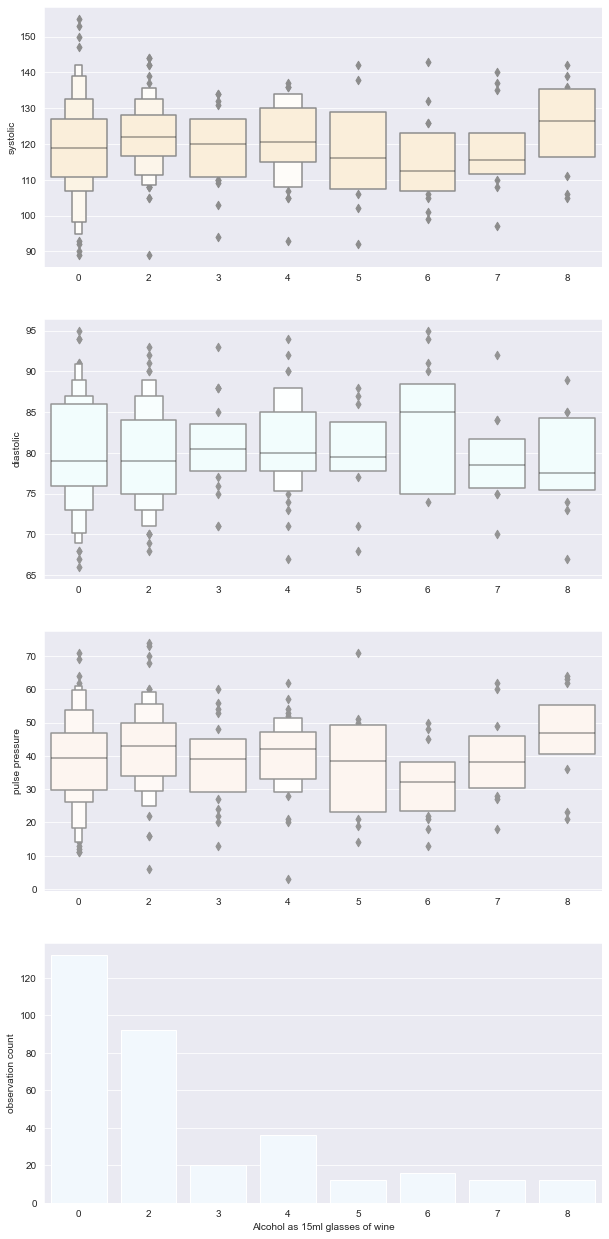

In [53]:
fig, axes = pyplot.subplots(nrows=4, ncols=1, figsize=(10, 22))

# Plot systolic
seaborn.boxenplot(data=dataset,
                  x='alcohol_cat', y='systolic',
                  ax=axes[0], palette=['papayawhip'])

# Plot diastolic
seaborn.boxenplot(data=dataset,
                  x='alcohol_cat', y='diastolic',
                  ax=axes[1], palette=['azure'])

# Plot pulse pressure
seaborn.boxenplot(data=dataset,
                  x='alcohol_cat', y='pulse pressure',
                  ax=axes[2], palette=['seashell'])

# Plot observation counts
seaborn.countplot(data=dataset,
                  x='alcohol_cat',
                  ax=axes[3], palette=['aliceblue'])

axes[0].set(xlabel=None)
axes[1].set(xlabel=None)
axes[2].set(xlabel=None)
axes[3].set(xlabel=f"Alcohol as 15ml glasses of wine", ylabel='observation count')

In [54]:
# Save the plots
fig.savefig(alcohol_jpg)
fig.savefig(alcohol_pdf)